# Calculating distances and iterating over trajectories with MDAnalysis

### In this notebook we learn how to use the methods of the atomgroup class to calculate bonds, distances between atoms, generate contact maps.
### We then see how to iterate over a trajectory, and calculate end-to-end distances and hydrogen bonds over time.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import MDAnalysis as mda
import MDAnalysis.lib.distances 
import nglview as nv

Create a Universe by loading the coordinates of a PEG - poly(ethyleneglycol) chain $HO(CH2CH2)_{20}OH$ 

In [4]:
u=mda.Universe('tutorial_MDA/PEG.prmtop','tutorial_MDA/PEG_03_prod.nc')

In [5]:
u

<Universe with 13406 atoms>

We loaded a trajectory with 50 frames, but for the first part of this tutorial we'll limit ourselves to look at one frame.

In [4]:
u.trajectory

<NCDFReader tutorial_MDA/PEG_03_prod.nc with 50 frames of 13406 atoms>

Calculate the center of mass/geometry of the polymer (not the entire Universe):

In [6]:
PEG=u.residues[0].atoms

In [7]:
poly = nv.show_mdanalysis(PEG)
poly

/anaconda/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:906: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  "".format(attrname, default))
/anaconda/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:906: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  "".format(attrname, default))
/anaconda/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:906: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  "".format(attrname, default))
/anaconda/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:906: UserWarning: Found no information for attr: 'tempfactors' Using default value of '0.0'
  "".format(attrname, default))


A Jupyter Widget

In [8]:
PEG.center_of_mass()

array([22.93376523, 26.82840903, 31.66687739])

Now, calculate the radius of gyration:

In [9]:
PEG.radius_of_gyration()

9.788402668965798

### Calculate the end-to-end distance of the PEG chain: calc_bonds

We can use the hydrogens in the capping -OH groups (type ho) as reference points.
First, select the two hydrogen atoms:

In [10]:
Hb, He = u.atoms.select_atoms("type ho")

Then, calculate the distance between their coordinates:

In [11]:
e2e_dist=np.linalg.norm(Hb.position-He.position)

In [12]:
e2e_dist

26.629349

The numpy function works, but if your system has periodic boundary conditions you want to make sure your distances are calculated using the minimum image convention. We can take care of is by using calc_bonds:

In [8]:
from MDAnalysis.lib import distances

In [14]:
distances.calc_bonds(Hb.position, He.position, box=u.dimensions)

26.62934987068575

### Other useful functions to calculate (dihedral) angles: calc_angles & calc_dihedrals
You might need these to check whether your force field yields the correct dihedral angle distribution:

In [15]:
C=u.atoms.select_atoms('type c3 and bonded type os')
O=u.atoms.select_atoms('type os')

Now with some creative index slicing we can look at the C-O-C angles and O-C-C-O dihedrals in our polymer chain.
Since the $CH_{2}$ groups have identical atom types, the simplest way to select only every other carbon is to slice the arrays.

In [16]:
np.rad2deg(distances.calc_angles(C.atoms[::2].positions, O.positions, C.atoms[1::2].positions, box=u.dimensions))

array([112.13267717, 109.14965224, 111.59562312, 115.00692717,
       115.99130492, 111.17841802, 114.22055856, 118.1690136 ,
       107.94286733, 114.26737791, 115.30460132, 111.66299609,
       118.244767  , 113.92092246, 113.0879812 , 112.62143551,
       121.71822062, 120.03081879, 117.2085765 ])

In [17]:
np.rad2deg(distances.calc_dihedrals(O.atoms[:-1].positions,C.atoms[:-2:2].positions,C.atoms[1:-2:2].positions,O.atoms[1:].positions,  box=u.dimensions))

array([ -28.77012048,   44.02457568,  -61.25349936,  -80.66968937,
         42.75184678,   27.3039674 ,  -49.54122278,  -20.06659924,
        -31.02635788,   36.79709104,  -38.34373281,   44.79130445,
       -157.68769315,   45.81115223,   65.46491982,   61.10125031,
        -83.08478549,  -42.69773016])

### Persistence length of a polymer 
This is also a built-in method. The persistence length is obtain by calculating the bond autocorrelation function and fitting it to an exponential decay

In [18]:
from MDAnalysis.analysis.polymer import PersistenceLength

In [19]:
backbone=PEG.atoms.select_atoms('not name H*')

In [20]:
pl=PersistenceLength([backbone]).run()
pl.perform_fit()

We can plot the autocorrelation using pl.results, or just look at the value of $l_{b}$:

In [21]:
pl.lb

1.5212205241499597

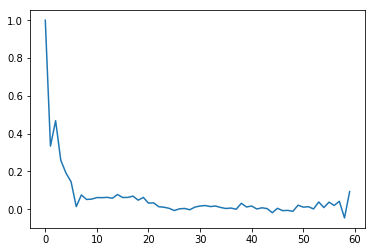

In [22]:
fig, ax = plt.subplots()
ax.plot(pl.results)
plt.show()

### Using distance_array and self_distance array to build contact maps

We can calculate quickly all possible distances between atomgroups and plot the resulting contact maps in 2D.
- **self_distance array** only takes one atomgroup
- **distance_array** takes two atomgroups and, unlike the calc_bonds/angles/dihedrals functions, they don't have to contain the same number of atoms.
- **capped_distance** is particularly useful when dealing with a big system: instead of looking for all possible distances, only considers atoms within a certain distance threshold.

In [23]:
d_CC = distances.self_distance_array(C.positions, box=u.dimensions)

The result is not super-informative, as we only have one polymer chain and the C-C distances obviously grow with the chain length. But we can also use this function to compare different frames of a trajectory.

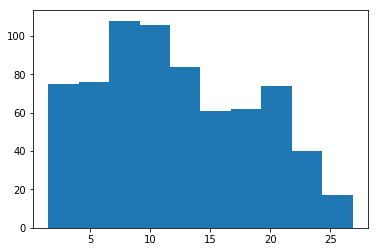

In [24]:
fig, ax = plt.subplots()
ax.hist(d_CC)
plt.show()

In [25]:
d_CC = distances.self_capped_distance(C.positions, max_cutoff=2,box=u.dimensions)

d_CC now contains a distribution of distances between neighboring carbons (cutoff=2). 
We could have used calc_bonds, but in this case we don't need to worry about slicing. We can give a min and max cutoff to only select the distances between neighboring C atoms.

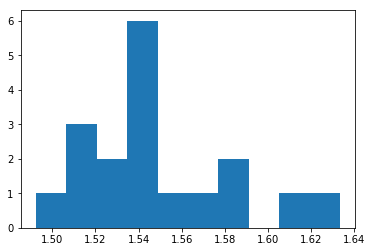

In [26]:
fig, ax = plt.subplots()
ax.hist(d_CC[1])
plt.show()

In [27]:
d_CO = distances.distance_array(C.positions, O.positions, box=u.dimensions)

In [28]:
d_CO.shape

(38, 19)

**distance_array** returns a bidimensional array that we can plot in 2D to generate a contact map:

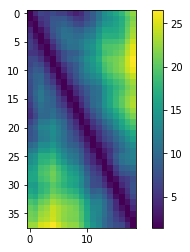

In [29]:
fig, ax = plt.subplots()
img=ax.imshow(d_CO)
plt.colorbar(img)
plt.show()

### Calculate hydrogen bonds between PEG and water

MDAnalysis.analysis already contains a hbonds module, but we're gonna build a function from scratch in order to play with the *distances* methods we've seen thus far.

1) Select hydrogen bond acceptors (PEG oxygens)

In [14]:
Acceptors=u.atoms.select_atoms("type os or type oh")

2) Select hydrogens (from water)

In [15]:
Hydrogens=u.atoms.select_atoms("type HW")

3) Pick the water molecules closest to the PEG chain using the **distance** (or **capped_distance**) method.

 A reasonable distance cutoff is 3 Å. We also need to consider pbc (u.dimensions).
 
 A useful feature of **distance**/**capped_distance** is that we can choose whether we need to return the distances, or only the list of Hydrogen, Acceptor pairs that satisfy our conditions. 
 
The main advantage of **capped_distance** is the speed. If your Universe is very big or you have a lot of solvent molecules, you'll see significant speedups:

In [32]:
%timeit distances.distance_array(Hydrogens.positions, Acceptors.positions, box=u.dimensions)

1 loop, best of 3: 1.32 s per loop


In [33]:
%timeit distances.capped_distance(Hydrogens.positions, Acceptors.positions, max_cutoff=3.0, box=u.dimensions)

100 loops, best of 3: 18.2 ms per loop


In [34]:
Acceptors

<AtomGroup with 4421 atoms>

Now we assign the indeces of Hydrogens and Acceptors forming the hydrogen bonds, which are returned by **capped_distance**:

In [25]:
d=distances.capped_distance(Hydrogens.positions, Acceptors.positions, max_cutoff=3, box=u.dimensions, return_distances=False)[0]

In [26]:
Hidx, Aidx = d.T

4) Select the Oxygen donors corresponding to the Hydrogens.

Since we'll use **calc_angles** to select the suitable O-H-A interactions,
we need to have a list of Oxygen donors that corresponds to the Hydrogens (there are 2 HW per OW). We then iterate over the list of Hydrogens and recover the Oxygen atom that belongs to the same residue:

In [27]:
Donors = []
for H in Hydrogens:
    r = H.residue
    O = r.atoms.select_atoms('type OW')[0]
    Donors.append(O)

In order to calculate the angles, we have to feed calc_angles three arrays of coordinates, so let's extract the coordinate of all donors since we cannot use the list as it is.

In [28]:
Donors_pos=np.array([d.position for d in Donors])

In [29]:
Acceptors.positions[Aidx]

array([123.84027 , 121.144806, -22.104435], dtype=float32)

5) Calculate the O-H-A angles and count how many of them are close to 180 degrees. That's how many H-bonds we have.

Now we can check whether the angle between Oxygen donors, hydrogens and acceptors is above a critical threshold (we picked 130 degrees), and save the number of hydrogen bonds into an array:

In [30]:
a = mda.lib.distances.calc_angles(Donors_pos[Hidx], Hydrogens.positions[Hidx], Acceptors.positions[Aidx], box=u.dimensions)
a_crit = np.deg2rad(130.0)
hbonds = np.where(a > a_crit)[0]

In [31]:
hbonds

array([], dtype=int64)

Now let's put it all into a function that we can then call over the entire trajectory:

In [16]:
def hbonds(Hydrogens, Acceptors):
    print('capped dist')
    d = distances.capped_distance(Hydrogens.positions, 
                                  Acceptors.positions, 
                                  max_cutoff=3, 
                                  box=Hydrogens.dimensions, 
                                  return_distances=False)
    Hidx, Aidx = d.T
    Donors = []
    #careful! this assumes the only H atoms come from water
    print('finding donors')
    for H in Hydrogens:
        r = H.residue
        O = r.atoms.select_atoms('type OW')[0]
        Donors.append(O)
    Donors = sum(Donors)

    print('calc_angles')
    a = distances.calc_angles(Donors.positions[Hidx], Hydrogens.positions[Hidx], Acceptors.positions[Aidx], box=Hydrogens.dimensions)
    a_crit = np.deg2rad(130.0)
    n_hbonds = np.where(a > a_crit)[0]
    return n_hbonds

## Now do it all again by iterating over a trajectory

### Plot e2e distance, hydrogen bonds, radius of gyration over time

In [14]:
u.trajectory[6]

< Timestep 6 with unit cell dimensions [53.81259  43.972904 57.204395 90.       90.       90.      ] >

In [46]:
u.trajectory.ts

< Timestep 0 with unit cell dimensions [53.809464 43.97035  57.20107  90.       90.       90.      ] >

When we iterate over the trajectory, the unit cell information and coordinates are automatically updated.
In order to calculate a quantity over the entire trajectory, we can create an empty list and add the property value at each frame.

In [47]:
e2e = []
Rg = []
com = []

for ts in u.trajectory:
    e2e.append(distances.calc_bonds(Hb.position, He.position, box=u.dimensions))
    Rg.append(PEG.atoms.radius_of_gyration())

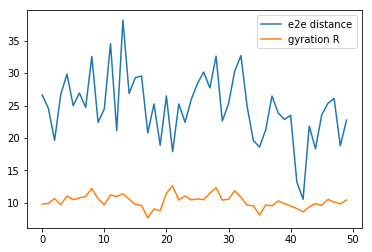

In [48]:
fig, ax = plt.subplots()
ax.plot(e2e, label='e2e distance')
ax.plot(Rg, label='gyration R')
plt.legend()
plt.show()

In [ ]:
#not working. kernel dies when trying to iterate over trj
hb = []
for ts in u.trajectory:
    print(ts.frame)
    hb.append(hbonds(Hydrogens, Acceptors))

0
capped dist
finding donors
calc_angles
1
capped dist
finding donors
calc_angles
2
capped dist
finding donors
calc_angles
3
capped dist
finding donors
calc_angles
4
capped dist
finding donors
calc_angles
5
capped dist
finding donors
calc_angles
6
capped dist
finding donors
calc_angles
7
capped dist
